# Comparing Performance of Base and Rechunked Zarr Versions of the NWM Retrospective Dataset for Time Series Queries

In this notebook we compare the performance of the Base Zarr provided by NOAA, with a version rechunked along the time dimension, for time series queries.

## Imports

First we import the libraries we'll need. PyNHD has useful wrappers around various web services that allow us to fetch hydrological data. S3FS and XArray are used to read NetCDF files from S3. SQL Alchemy and GeoPandas are used to construct dataframes from a PostGIS database.

In [91]:
from tqdm.notebook import tqdm
from pynhd.pynhd import NHD, NHDPlusHR, WaterData
import os, s3fs, fsspec, json, time
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import sqlalchemy as sa
import seaborn as sns

from datetime import datetime, timedelta

### Disable Warnings for Clarity

In [92]:
import warnings
warnings.filterwarnings('ignore')

## Helper Functions for Flowline Retrieval

These are two ways to get flowlines, either from the NHD web service using HyRiver's `pynhd` package, or from our database where we've ingested the same data. The NHD web service is more portable but slower.

In [93]:
def get_flowlines_from_db(huc):
    con = sa.create_engine(
        "{driver}://{user}:{password}@{host}/{database}".format(
            driver="postgresql+psycopg2",
            user=os.getenv("PGUSER"),
            password=os.getenv("PGPASSWORD"),
            host=os.getenv("PGHOST"),
            database="nhdplusv2",
        )
    )

    sql = f"""
        SELECT comid, shape
        FROM nhdflowline_network
        WHERE ST_Intersects(
            shape,
            ST_Transform(
                ST_SetSRID(
                    ST_GeomFromText('{huc.geometry[0].wkt}'),
                    4326),
                4269)
        )
    """
    
    return gpd.GeoDataFrame.from_postgis(sql, con, geom_col='shape')

In [94]:
def get_flowlines_from_web(huc):
    return NHD('flowline_mr').bygeom(huc.geometry[0].geoms[0])

## Pick an Area of Interest

We want to look at streamflow predictions for a particular area. In this example, we're looking at the Schuylkill HUC-8.

CPU times: user 215 ms, sys: 89 ms, total: 304 ms
Wall time: 1.82 s


<AxesSubplot:>

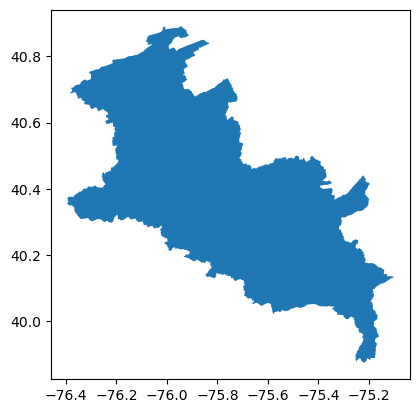

In [95]:
%%time

HUC = '02040203'

huc = WaterData('wbd08_20201006').byid('huc8', HUC)
huc.geometry.plot()

Get flowlines contained within that shape

CPU times: user 436 ms, sys: 113 ms, total: 548 ms
Wall time: 728 ms


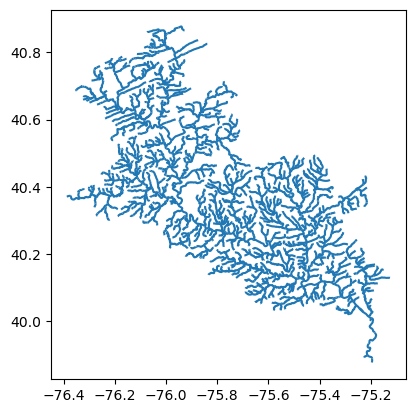

In [96]:
%%time

flowlines = get_flowlines_from_db(huc)
flowlines.plot()

nhd_comids = list(set([int(f) for f in flowlines['comid']]))

## Setup Experiments

We'll run the queries five times, once for a month, once for a year, and once for a decade.

In [97]:
nb_reaches = len(nhd_comids)
nb_repeats = 5
time_ranges = [ 
    slice('1990-01-01', '1990-02-01'),
    slice('1990-01-01', '1991-01-01'),
    slice('1990-01-01', '2000-01-01'),
]

query_map = {
    '1_mean_features_mean_day': (lambda ds: ds.streamflow.mean(dim='feature_id').groupby('time.dayofyear').mean().values),
    '2_mean_day': (lambda ds: ds.streamflow.groupby('time.dayofyear').mean().values),
    '3_mean_week': (lambda ds: ds.streamflow.groupby('time.weekofyear').mean().values)
}

zarrs = {
    'base': 's3://noaa-nwm-retrospective-2-1-zarr-pds/chrtout.zarr',
    'rechunked': 's3://azavea-noaa-hydro-data/experiments/jp/rechunk/output.zarr',
}

experiments = [] 

In [98]:
def run_experiment(name, zarr, query_map, time_ranges, nb_repeats, nb_reaches):
    ds = xr.open_zarr(zarr)
    for time_range in tqdm(time_ranges, desc='time ranges', leave=False):
        sub_ds = ds.sel(feature_id=nhd_comids, time=time_range)

        nb_days = (pd.to_datetime(time_range.stop) - pd.to_datetime(time_range.start)).days

        chunk_sizes = np.array([ds.streamflow.chunks[0][0], ds.streamflow.chunks[1][0]])
        time_chunk_sz = chunk_sizes[0]
        feature_id_chunk_sz = chunk_sizes[1]

        for qname, qfunc in tqdm(query_map.items(), desc='query', leave=False):
            times = []
            for _ in tqdm(range(nb_repeats), desc='repeat', leave=False):
                start_time = time.time()
                vals = qfunc(sub_ds)
                elapsed = time.time() - start_time
                times.append(elapsed)
            times = np.array(times)
            exp_row = {
                'query': qname,
                'time_mean': times.mean(),
                'time_std': times.std(), 
                'nb_reaches': nb_reaches,
                'nb_days': nb_days,
                'nb_repeats': nb_repeats,
                'source': name,
                'time_chunk_sz': time_chunk_sz,
                'feature_id_chunk_sz': feature_id_chunk_sz
            }
            experiments.append(exp_row)
        del sub_ds
    del ds

### Run Experiments for Base Zarr

These cause about 151 GB of data transfer.

In [99]:
%%time

run_experiment('base', zarrs['base'], query_map, time_ranges, nb_repeats, nb_reaches)

time ranges:   0%|          | 0/3 [00:00<?, ?it/s]

query:   0%|          | 0/3 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

query:   0%|          | 0/3 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

query:   0%|          | 0/3 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 49min 52s, sys: 22min 41s, total: 1h 12min 33s
Wall time: 29min 53s


### Run Experiments for Rechunked Zarr

These cause about 6.6 GB of data transfer.

In [100]:
%%time

run_experiment('rechunked', zarrs['rechunked'], query_map, time_ranges, nb_repeats, nb_reaches)

time ranges:   0%|          | 0/3 [00:00<?, ?it/s]

query:   0%|          | 0/3 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

query:   0%|          | 0/3 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

query:   0%|          | 0/3 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

repeat:   0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 6min 47s, sys: 2min 1s, total: 8min 49s
Wall time: 5min 19s


In [101]:
experiments

[{'query': '1_mean_features_mean_day',
  'time_mean': 1.5481578350067138,
  'time_std': 0.18449270732983566,
  'nb_reaches': 1898,
  'nb_days': 31,
  'nb_repeats': 5,
  'source': 'base',
  'time_chunk_sz': 672,
  'feature_id_chunk_sz': 30000},
 {'query': '2_mean_day',
  'time_mean': 1.565456008911133,
  'time_std': 0.08469266368219709,
  'nb_reaches': 1898,
  'nb_days': 31,
  'nb_repeats': 5,
  'source': 'base',
  'time_chunk_sz': 672,
  'feature_id_chunk_sz': 30000},
 {'query': '3_mean_week',
  'time_mean': 1.4762969493865967,
  'time_std': 0.23376418756112233,
  'nb_reaches': 1898,
  'nb_days': 31,
  'nb_repeats': 5,
  'source': 'base',
  'time_chunk_sz': 672,
  'feature_id_chunk_sz': 30000},
 {'query': '1_mean_features_mean_day',
  'time_mean': 10.647990798950195,
  'time_std': 0.5668903044246235,
  'nb_reaches': 1898,
  'nb_days': 365,
  'nb_repeats': 5,
  'source': 'base',
  'time_chunk_sz': 672,
  'feature_id_chunk_sz': 30000},
 {'query': '2_mean_day',
  'time_mean': 13.598707818

In [102]:
df = pd.DataFrame(experiments)
df

,query,time_mean,time_std,nb_reaches,nb_days,nb_repeats,source,time_chunk_sz,feature_id_chunk_sz
0,1_mean_features_mean_day,1.548158,0.184493,1898,31,5,base,672,30000
1,2_mean_day,1.565456,0.084693,1898,31,5,base,672,30000
2,3_mean_week,1.476297,0.233764,1898,31,5,base,672,30000
3,1_mean_features_mean_day,10.647991,0.566890,1898,365,5,base,672,30000
4,2_mean_day,13.598708,0.378162,1898,365,5,base,672,30000
5,3_mean_week,9.929481,0.542499,1898,365,5,base,672,30000
6,1_mean_features_mean_day,105.165571,7.956668,1898,3652,5,base,672,30000
7,2_mean_day,122.379279,1.059752,1898,3652,5,base,672,30000
8,3_mean_week,91.530312,0.852376,1898,3652,5,base,672,30000
9,1_mean_features_mean_day,1.111133,0.071721,1898,31,5,rechunked,30000,672


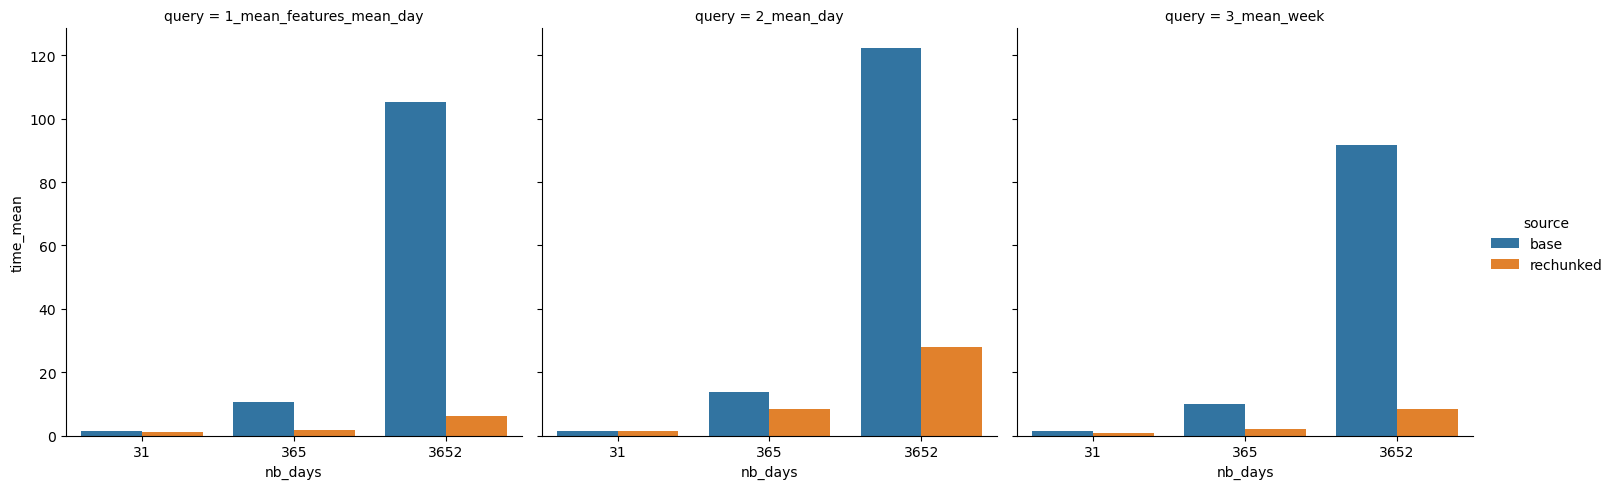

In [103]:
plot = sns.catplot(x='nb_days', y='time_mean', col='query', hue='source', kind='bar', data=df)

In [106]:
def speedup(group):
    base_time = list(group[group['source'] == 'base']['time_mean'])[0]
    rechunked_time = list(group[group['source'] == 'rechunked']['time_mean'])[0]
    
    return base_time / rechunked_time

df2 = pd.DataFrame(df.groupby(['query', 'nb_days'], group_keys=False).apply(speedup).reset_index())
df2.columns = ['query', 'nb_days', 'speedup']
df2

,query,nb_days,speedup
0,1_mean_features_mean_day,31,1.393315
1,1_mean_features_mean_day,365,5.553896
2,1_mean_features_mean_day,3652,16.901529
3,2_mean_day,31,1.082824
4,2_mean_day,365,1.603014
5,2_mean_day,3652,4.399794
6,3_mean_week,31,1.539599
7,3_mean_week,365,4.858592
8,3_mean_week,3652,10.781553


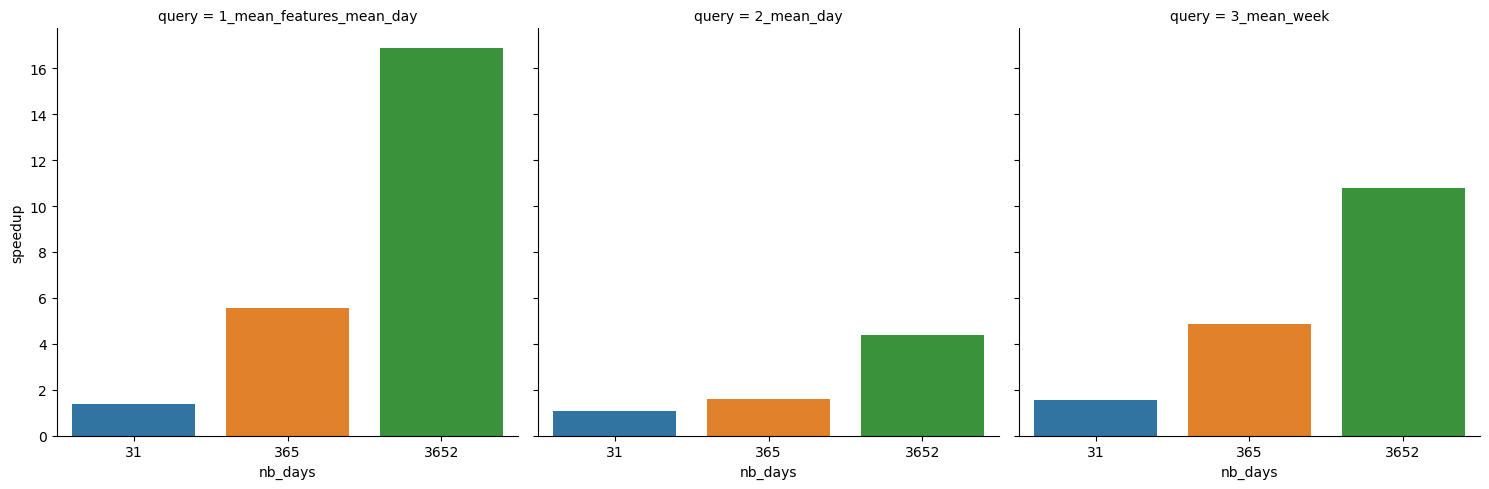

In [107]:
sns.catplot(x='nb_days', y='speedup', col='query', kind='bar', data=df2)